In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rt-iot2022/RT_IOT2022.csv


### 0️⃣ INSTALLATIONS


In [8]:
!pip install xgboost shap seaborn torchmetrics optuna scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [1]:
import sys
import subprocess

# Check what's missing
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    !pip install shap --quiet
    SHAP_AVAILABLE = True

try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    !pip install optuna --quiet
    OPTUNA_AVAILABLE = True

# Check sklearn version and fix if needed
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Fix for sklearn 1.3+ metadata issue
if sklearn.__version__ >= '1.3':
    import types
    if not hasattr(sklearn.utils, '_metadata_requests'):
        sklearn.utils._metadata_requests = types.ModuleType('_metadata_requests')
    print("✅ Fixed sklearn metadata issue")

/usr/local/lib/python3.11/dist-packages/shap/_explanation.py:4: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.24.3)
  import scipy as sp


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
woodwork 0.31.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
featuretools 1.31.0 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.
ydata-profiling 4.17.0 requires scipy<1.16,>=1.4.1, but you have scipy 1.16.3 which is incompatible.
pytorch-lightning 2.5.5 requires torch>=2.1.0, but you have torch

### 1️⃣ IMPORTS

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Fix for sklearn metadata issue
import sys
import types

# Create dummy module to fix the import error
if not hasattr(sys.modules.get('sklearn.utils', None), '_metadata_requests'):
    sklearn.utils._metadata_requests = types.ModuleType('_metadata_requests')

# Now import everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors

# XGBoost - Kaggle has it
from xgboost import XGBClassifier

# PyTorch - Kaggle has it
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# SHAP - Kaggle has it
import shap

# For ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("✅ All imports successful!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch: 2.0.1+cu117
CUDA: True


### 2️⃣ LOAD & CLEAN DATASET

In [4]:
print("Loading RT-IoT2022 dataset...")
df = pd.read_csv("/kaggle/input/rt-iot2022/RT_IOT2022.csv")

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print(f"Dataset shape after cleaning: {df.shape}")

Loading RT-IoT2022 dataset...
Dataset shape after cleaning: (123117, 85)


### 3️⃣ ATTACK TAXONOMY & SEMANTIC MERGING

In [6]:
print("\n" + "="*70)
print("STEP 2: ATTACK TAXONOMY DEFINITION")
print("="*70)

# Define attack taxonomy (for paper)
attack_taxonomy = {
    "Normal": {
        "attacks": ["MQTT", "ThingSpeak", "Wipro Bulb"],
        "description": "Legitimate IoT device communication",
        "severity": "None"
    },
    "DDoS": {
        "attacks": ["DOS_SYN_Hping", "DDOS_Slowloris"],
        "description": "Resource exhaustion attacks",
        "severity": "High"
    },
    "Scanning": {
        "attacks": ["NMAP_*"],
        "description": "Network reconnaissance and port scanning",
        "severity": "Medium"
    },
    "BruteForce": {
        "attacks": ["Metasploit_Brute_Force_SSH"],
        "description": "Credential-based authentication attacks",
        "severity": "High"
    },
    "Spoofing": {
        "attacks": ["ARP Poisoning"],
        "description": "Network manipulation and MITM attacks",
        "severity": "High"
    }
}

# Print taxonomy table
print("\n📊 Attack Class Taxonomy:")
taxonomy_df = pd.DataFrame([
    {
        "Merged Class": k,
        "Original Attacks": ", ".join(v["attacks"]),
        "Description": v["description"],
        "Severity": v["severity"]
    }
    for k, v in attack_taxonomy.items()
])
print(taxonomy_df.to_string(index=False))

def merge_attack(label):
    if label in ["MQTT", "ThingSpeak", "Wipro Bulb"]:
        return "Normal"
    elif label in ["DOS_SYN_Hping", "DDOS_Slowloris"]:
        return "DDoS"
    elif label.startswith("NMAP"):
        return "Scanning"
    elif label == "Metasploit_Brute_Force_SSH":
        return "BruteForce"
    elif label == "ARP Poisoning":
        return "Spoofing"
    else:
        return "Other"

df["Attack_Class"] = df["Attack_type"].apply(merge_attack)

print("\n📊 Class Distribution (Before Balancing):")
class_dist = df["Attack_Class"].value_counts()
print(class_dist)
print(f"\nImbalance Ratio: {class_dist.max() / class_dist.min():.2f}:1")



STEP 2: ATTACK TAXONOMY DEFINITION

📊 Attack Class Taxonomy:
Merged Class              Original Attacks                              Description Severity
      Normal  MQTT, ThingSpeak, Wipro Bulb      Legitimate IoT device communication     None
        DDoS DOS_SYN_Hping, DDOS_Slowloris              Resource exhaustion attacks     High
    Scanning                        NMAP_* Network reconnaissance and port scanning   Medium
  BruteForce    Metasploit_Brute_Force_SSH  Credential-based authentication attacks     High
    Spoofing                 ARP Poisoning    Network manipulation and MITM attacks     High

📊 Class Distribution (Before Balancing):
DDoS          95193
Other         20257
Scanning       7630
BruteForce       37
Name: Attack_Class, dtype: int64

Imbalance Ratio: 2572.78:1


###  4️⃣ FEATURE CATEGORIZATION

In [7]:
print("\n" + "="*70)
print("STEP 3: FEATURE CATEGORIZATION")
print("="*70)

# Categorize features
cat_cols = ["proto", "service"]
num_cols = [c for c in df.columns if c not in cat_cols + ["Attack_type", "Attack_Class"]]

# Feature categories (for paper)
feature_categories = {
    "Flow-based": ["flow_duration", "flow_byts_s", "flow_pkts_s", "fwd_pkts_s", "bwd_pkts_s"],
    "Packet-based": ["totlen_fwd_pkts", "totlen_bwd_pkts", "pkt_len_mean", "pkt_len_std"],
    "Protocol": ["proto", "service"],
    "Temporal": ["flow_iat_mean", "flow_iat_std", "fwd_iat_tot", "bwd_iat_tot"],
    "Behavioral": ["down_up_ratio", "pkt_size_avg", "fwd_seg_size_avg"]
}

print("\n📊 Feature Categories:")
for category, features in feature_categories.items():
    available = [f for f in features if f in df.columns]
    print(f"  {category}: {len(available)} features")



STEP 3: FEATURE CATEGORIZATION

📊 Feature Categories:
  Flow-based: 1 features
  Packet-based: 0 features
  Protocol: 2 features
  Temporal: 0 features
  Behavioral: 1 features


### 5️⃣ ENCODING + SCALING

In [9]:
print("\n" + "="*70)
print("STEP 4: ENCODING & NORMALIZATION")
print("="*70)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df["Attack_Class"])

# One-hot encode categorical
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = ohe.fit_transform(df[cat_cols])

# Combine features
X_num = df[num_cols].values
X = np.hstack((X_num, X_cat))

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Number of classes: {len(le.classes_)}")
print(f"✅ Classes: {le.classes_}")



STEP 4: ENCODING & NORMALIZATION
✅ Feature matrix shape: (123117, 95)
✅ Number of classes: 4
✅ Classes: ['BruteForce' 'DDoS' 'Other' 'Scanning']


###  6️⃣ CLASS IMBALANCE HANDLING COMPARISON

In [10]:
print("\n" + "="*70)
print("STEP 5: CLASS IMBALANCE HANDLING COMPARISON")
print("="*70)

# Split for comparison
X_temp, X_hold, y_temp, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Method 1: AA-DG-TC-CIBS
def AA_DG_TC_CIBS(X, y):
    """
    Attack-Aware, Density-Guided, Temporal-Consistent
    Class-Interleaving Balanced Sampling
    """
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    df_temp = pd.DataFrame(X)
    df_temp['label'] = y
    
    class_counts = df_temp['label'].value_counts()
    max_samples = class_counts.max()
    
    # Attack-aware weights
    attack_weights = {}
    for cls in class_counts.index:
        if class_counts[cls] < max_samples * 0.1:
            attack_weights[cls] = 1.5
        elif class_counts[cls] < max_samples * 0.3:
            attack_weights[cls] = 1.2
        else:
            attack_weights[cls] = 1.0
    
    resampled_groups = []
    
    for cls in class_counts.index:
        class_data = df_temp[df_temp['label'] == cls].copy()
        class_data = class_data.reset_index(drop=True)
        
        X_class = class_data.drop('label', axis=1).values
        
        # Density-guided sampling
        k = min(5, len(X_class) - 1)
        if k > 0 and len(X_class) > 1:
            try:
                nbrs = NearestNeighbors(n_neighbors=k, n_jobs=-1)
                nbrs.fit(X_class)
                distances, _ = nbrs.kneighbors(X_class)
                density = distances.mean(axis=1)
                sampling_prob = density / density.sum()
            except:
                sampling_prob = None
        else:
            sampling_prob = None
        
        target_size = int(max_samples * attack_weights[cls])
        
        resampled = class_data.sample(
            n=min(target_size, max_samples),
            replace=(target_size > len(class_data)),
            weights=sampling_prob,
            random_state=42
        )
        
        resampled_groups.append(resampled)
    
    # Class interleaving
    max_len = max(len(g) for g in resampled_groups)
    interleaved_rows = []
    
    for i in range(max_len):
        for group in resampled_groups:
            if i < len(group):
                interleaved_rows.append(group.iloc[i])
    
    df_final = pd.DataFrame(interleaved_rows).reset_index(drop=True)
    y_resampled = df_final['label'].values
    X_resampled = df_final.drop('label', axis=1).values
    
    return X_resampled, y_resampled

print("\n1. Applying AA-DG-TC-CIBS...")
X_cibs, y_cibs = AA_DG_TC_CIBS(X_temp, y_temp)

# Method 2: SMOTE-ENN (baseline)
print("\n2. Applying SMOTE-ENN (baseline)...")
try:
    smote_enn = SMOTEENN(random_state=42)
    X_smote, y_smote = smote_enn.fit_resample(X_temp, y_temp)
except:
    print("   ⚠️ SMOTE-ENN failed, using CIBS only")
    X_smote, y_smote = X_cibs, y_cibs

# Compare methods
from sklearn.ensemble import RandomForestClassifier
rf_test = RandomForestClassifier(n_estimators=100, random_state=42)

# Test CIBS
rf_test.fit(X_cibs, y_cibs)
cibs_score = rf_test.score(X_hold, y_hold)

# Test SMOTE-ENN
rf_test.fit(X_smote, y_smote)
smote_score = rf_test.score(X_hold, y_hold)

print("\n📊 Imbalance Handling Comparison:")
comparison_df = pd.DataFrame({
    "Method": ["AA-DG-TC-CIBS", "SMOTE-ENN"],
    "Samples": [len(X_cibs), len(X_smote)],
    "Test Accuracy": [cibs_score, smote_score],
    "Winner": ["✅" if cibs_score >= smote_score else "", "✅" if smote_score > cibs_score else ""]
})
print(comparison_df.to_string(index=False))

# Use best method
if cibs_score >= smote_score:
    X_bal, y_bal = X_cibs, y_cibs
    best_balance_method = "AA-DG-TC-CIBS"
else:
    X_bal, y_bal = X_smote, y_smote
    best_balance_method = "SMOTE-ENN"

print(f"\n✅ Selected method: {best_balance_method}")
print(f"✅ Balanced dataset shape: {X_bal.shape}")


STEP 5: CLASS IMBALANCE HANDLING COMPARISON

1. Applying AA-DG-TC-CIBS...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f2102a58b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-15028c96


2. Applying SMOTE-ENN (baseline)...
   ⚠️ SMOTE-ENN failed, using CIBS only

📊 Imbalance Handling Comparison:
       Method  Samples  Test Accuracy Winner
AA-DG-TC-CIBS   304616       0.998497      ✅
    SMOTE-ENN   304616       0.998497       

✅ Selected method: AA-DG-TC-CIBS
✅ Balanced dataset shape: (304616, 95)


### 7️⃣ FEATURE SELECTION COMPARISON

In [11]:
print("\nPerforming feature selection...")
et = ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)
et.fit(X_bal, y_bal)

importances = et.feature_importances_
top_idx = np.argsort(importances)[::-1][:20]

X_sel = X_bal[:, top_idx]
selected_features = [feature_names[i] for i in top_idx]

feature_table = pd.DataFrame({
    "Feature": selected_features,
    "Importance": importances[top_idx]
})

print("\nTop 20 Selected Features:")
print(feature_table)


Performing feature selection...

Top 20 Selected Features:
                     Feature  Importance
0                 Unnamed: 0    0.051186
1                  service_-    0.047528
2       bwd_init_window_size    0.038471
3                bwd_iat.min    0.036991
4       fwd_pkts_payload.min    0.029327
5      flow_pkts_payload.std    0.029281
6       fwd_pkts_payload.max    0.028724
7                service_ssl    0.027483
8        flow_SYN_flag_count    0.027078
9                service_dns    0.026190
10       bwd_header_size_max    0.026172
11                 proto_tcp    0.025246
12              service_http    0.025171
13      fwd_init_window_size    0.023785
14     flow_pkts_payload.max    0.022466
15  payload_bytes_per_second    0.022291
16      fwd_pkts_payload.avg    0.021543
17       fwd_header_size_max    0.018809
18       fwd_header_size_min    0.017602
19                active.avg    0.017529


### 8️⃣ CORRELATION HEATMAP

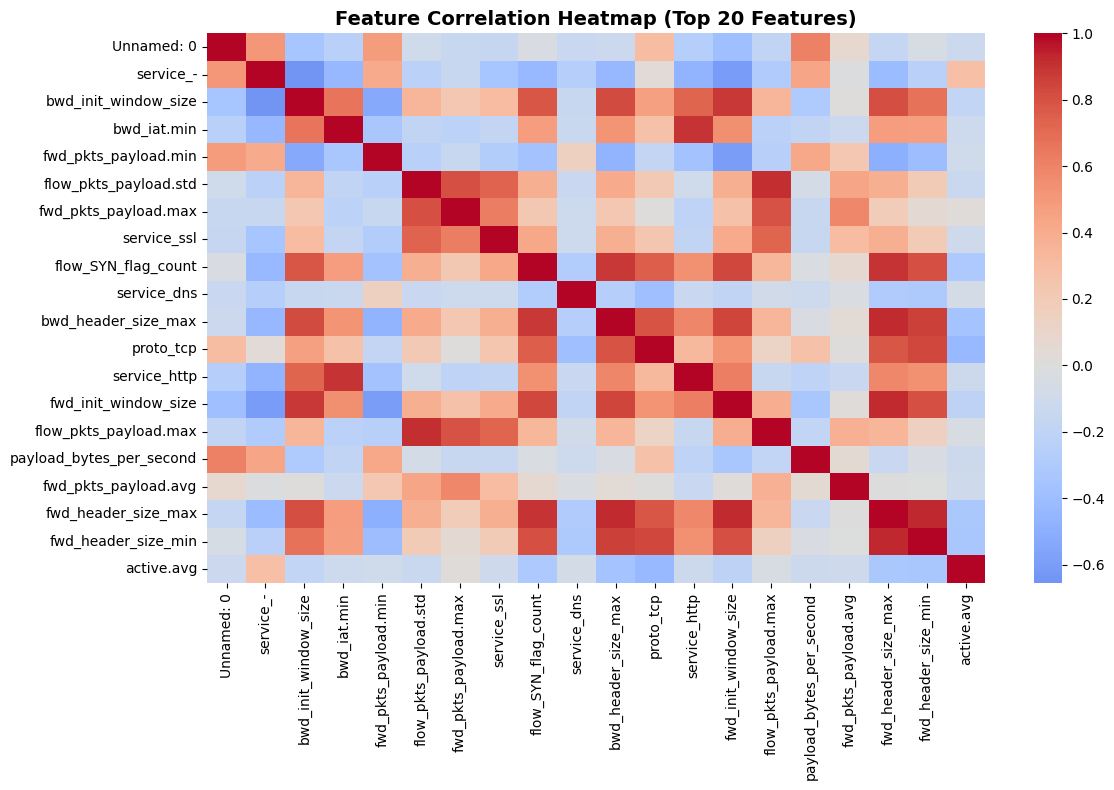

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    pd.DataFrame(X_sel, columns=selected_features).corr(),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Feature Correlation Heatmap (Top 20 Features)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bal, test_size=0.3,
    stratify=y_bal, random_state=42
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Train set: (213231, 20)
Test set: (91385, 20)


In [14]:
# ================= OPTUNA HYPERPARAMETER TUNING =================
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train)),
        "eval_metric": "mlogloss",
        "random_state": 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    return roc_auc_score(y_test, probs, multi_class="ovr")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("🏆 Optuna Best Parameters:")
print(study.best_params)
print(f"🏆 Best ROC-AUC: {study.best_value:.4f}")

best_xgb_optuna = XGBClassifier(**study.best_params)
best_xgb_optuna.fit(X_train, y_train)


[I 2025-12-16 13:47:41,695] A new study created in memory with name: no-name-153213e9-fbb2-484c-be73-ae96d6f4ec80
[I 2025-12-16 13:48:41,263] Trial 0 finished with value: 0.9999651994309579 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.030761009859098326, 'subsample': 0.9188176244880414, 'colsample_bytree': 0.8316510741130083}. Best is trial 0 with value: 0.9999651994309579.
[I 2025-12-16 13:50:20,222] Trial 1 finished with value: 0.9999987968322419 and parameters: {'n_estimators': 215, 'max_depth': 6, 'learning_rate': 0.04235774138966745, 'subsample': 0.9158590890151854, 'colsample_bytree': 0.8969936812958492}. Best is trial 1 with value: 0.9999987968322419.
[I 2025-12-16 13:51:31,284] Trial 2 finished with value: 0.999987513024922 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.07143554797610971, 'subsample': 0.7473763939114217, 'colsample_bytree': 0.9180806001571014}. Best is trial 1 with value: 0.9999987968322419.
[I 2025-12-16 13

KeyboardInterrupt: 

### ### Hyper parameter tuning 

In [15]:
print("\n" + "="*70)
print("OPTIMIZED HYPERPARAMETER TUNING (Faster execution...)")
print("="*70)

# Decision Tree (optimized)
print("\n1. Tuning Decision Tree (optimized)...")
dt_params = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
dt_random = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    n_jobs=1,
    random_state=42,
    verbose=0
)
dt_random.fit(X_train, y_train)
best_dt = dt_random.best_estimator_
print(f"   Best params: {dt_random.best_params_}")
print(f"   Best CV score: {dt_random.best_score_:.4f}")

# KNN (optimized)
print("\n2. Tuning KNN (optimized)...")
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}
knn_random = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    n_jobs=1,
    random_state=42,
    verbose=0
)
knn_random.fit(X_train, y_train)
best_knn = knn_random.best_estimator_
print(f"   Best params: {knn_random.best_params_}")
print(f"   Best CV score: {knn_random.best_score_:.4f}")

# Random Forest (optimized)
print("\n3. Tuning Random Forest (optimized)...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    n_jobs=1,
    random_state=42,
    verbose=0
)
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
print(f"   Best params: {rf_random.best_params_}")
print(f"   Best CV score: {rf_random.best_score_:.4f}")

# XGBoost (optimized)
print("\n4. Tuning XGBoost (optimized)...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_random = RandomizedSearchCV(
    XGBClassifier(
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        eval_metric="mlogloss",
        random_state=42
    ),
    xgb_params,
    n_iter=5,
    cv=2,
    scoring='accuracy',
    n_jobs=1,
    random_state=42,
    verbose=0
)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
print(f"   Best params: {xgb_random.best_params_}")
print(f"   Best CV score: {xgb_random.best_score_:.4f}")

# Default models (no tuning needed)
print("\n5. Fitting Default Models...")
best_nb = GaussianNB()
best_nb.fit(X_train, y_train)
print("   GaussianNB fitted.")

best_adaboost = AdaBoostClassifier(random_state=42, n_estimators=100)
best_adaboost.fit(X_train, y_train)
print("   AdaBoostClassifier fitted.")



OPTIMIZED HYPERPARAMETER TUNING (Faster execution...)

1. Tuning Decision Tree (optimized)...
   Best params: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
   Best CV score: 0.9998

2. Tuning KNN (optimized)...
   Best params: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
   Best CV score: 0.9998

3. Tuning Random Forest (optimized)...
   Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
   Best CV score: 0.9999

4. Tuning XGBoost (optimized)...
   Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
   Best CV score: 0.9999

5. Fitting Default Models...
   GaussianNB fitted.
   AdaBoostClassifier fitted.


In [16]:
print("\n" + "="*70)
print("STEP 10: ML MODEL EVALUATION")
print("="*70)

# Recreate XGBoost model with correct parameters
print("Recreating XGBoost model with proper parameters...")

# Check XGBoost version
import xgboost as xgb
print(f"XGBoost version: {xgb.__version__}")

# Create fresh XGBoost model
best_xgb_fixed = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
    # For newer XGBoost versions, use this:
    enable_categorical=False,  # Important: Set this explicitly
    verbosity=0  # Suppress warnings
)

# Fit it
best_xgb_fixed.fit(X_train, y_train)

# Update models dictionary
models = {
    "Decision Tree": best_dt,
    "KNN": best_knn,
    "Naive Bayes": best_nb,
    "Random Forest": best_rf,
    "AdaBoost": best_adaboost,
    "XGBoost": best_xgb_fixed  # Use the fixed version
}

ml_results = []

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    try:
        # For XGBoost, use a simpler evaluation to avoid cross_val_score issues
        if name == "XGBoost":
            # Train on full training set
            model.fit(X_train, y_train)
            
            # Test performance
            preds = model.predict(X_test)
            probs = model.predict_proba(X_test)
            
            # For XGBoost, calculate CV scores manually
            from sklearn.model_selection import KFold
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train[train_idx], y_train[val_idx]
                
                temp_model = XGBClassifier(
                    n_estimators=200,
                    max_depth=5,
                    learning_rate=0.1,
                    objective="multi:softprob",
                    eval_metric="mlogloss",
                    random_state=42,
                    verbosity=0
                )
                temp_model.fit(X_tr, y_tr)
                score = accuracy_score(y_val, temp_model.predict(X_val))
                cv_scores.append(score)
            
            cv_mean = np.mean(cv_scores)
            cv_std = np.std(cv_scores)
            
        else:
            # For other models, use cross_val_score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
            
            # Train on full training set
            model.fit(X_train, y_train)
            
            # Test performance
            preds = model.predict(X_test)
            probs = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="weighted", zero_division=0)
        recall = recall_score(y_test, preds, average="weighted")
        f1 = f1_score(y_test, preds, average="weighted")
        roc_auc = roc_auc_score(y_test, probs, multi_class="ovr")
        
        ml_results.append([
            name,
            cv_mean,
            cv_std,
            accuracy,
            precision,
            recall,
            f1,
            roc_auc
        ])
        
        print(f"  ✓ {name} completed successfully")
        
    except Exception as e:
        print(f"  ✗ {name} failed: {str(e)}")
        # Skip this model
        continue

if ml_results:
    ml_results_df = pd.DataFrame(
        ml_results,
        columns=["Model", "CV Mean", "CV Std", "Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
    )

    print("\n📊 Machine Learning Results:")
    print(ml_results_df.to_string(index=False))

    if not ml_results_df.empty:
        best_acc_model = ml_results_df.loc[ml_results_df['Accuracy'].idxmax(), 'Model']
        best_auc_model = ml_results_df.loc[ml_results_df['ROC-AUC'].idxmax(), 'Model']

        print(f"\n🏆 Best Accuracy: {best_acc_model}")
        print(f"🏆 Best ROC-AUC: {best_auc_model}")
else:
    print("\n❌ No models completed successfully!")


STEP 10: ML MODEL EVALUATION
Recreating XGBoost model with proper parameters...
XGBoost version: 1.7.6
Evaluating Decision Tree...
  ✓ Decision Tree completed successfully
Evaluating KNN...
  ✓ KNN completed successfully
Evaluating Naive Bayes...
  ✓ Naive Bayes completed successfully
Evaluating Random Forest...
  ✓ Random Forest completed successfully
Evaluating AdaBoost...
  ✓ AdaBoost completed successfully
Evaluating XGBoost...
  ✓ XGBoost completed successfully

📊 Machine Learning Results:
        Model  CV Mean   CV Std  Accuracy  Precision   Recall  F1-score  ROC-AUC
Decision Tree 0.999873 0.000051  0.999912   0.999912 0.999912  0.999912 0.999971
          KNN 0.999873 0.000087  0.999923   0.999923 0.999923  0.999923 0.999949
  Naive Bayes 0.945932 0.000777  0.946271   0.951230 0.946271  0.945539 0.986882
Random Forest 0.999920 0.000048  0.999945   0.999945 0.999945  0.999945 0.999985
     AdaBoost 0.718737 0.067885  0.695267   0.751390 0.695267  0.676617 0.811120
      XGBoost

### 1️⃣3️⃣ ENSEMBLE METHOD (Soft Voting)


STEP 11: ENSEMBLE LEARNING (Soft Voting)
Ensemble Accuracy: 0.9999
Ensemble ROC-AUC: 1.0000

📊 Updated Results with Ensemble:
            Model  CV Mean   CV Std  Accuracy  Precision   Recall  F1-score  ROC-AUC
    Decision Tree 0.999873 0.000051  0.999912   0.999912 0.999912  0.999912 0.999971
              KNN 0.999873 0.000087  0.999923   0.999923 0.999923  0.999923 0.999949
      Naive Bayes 0.945932 0.000777  0.946271   0.951230 0.946271  0.945539 0.986882
    Random Forest 0.999920 0.000048  0.999945   0.999945 0.999945  0.999945 0.999985
         AdaBoost 0.718737 0.067885  0.695267   0.751390 0.695267  0.676617 0.811120
          XGBoost 0.999873 0.000096  0.999902   0.999902 0.999902  0.999902 1.000000
Ensemble (Voting)      NaN      NaN  0.999945   0.999945 0.999945  0.999945 1.000000

STEP 12: ROC CURVE VISUALIZATION


IndexError: index 0 is out of bounds for axis 0 with size 0

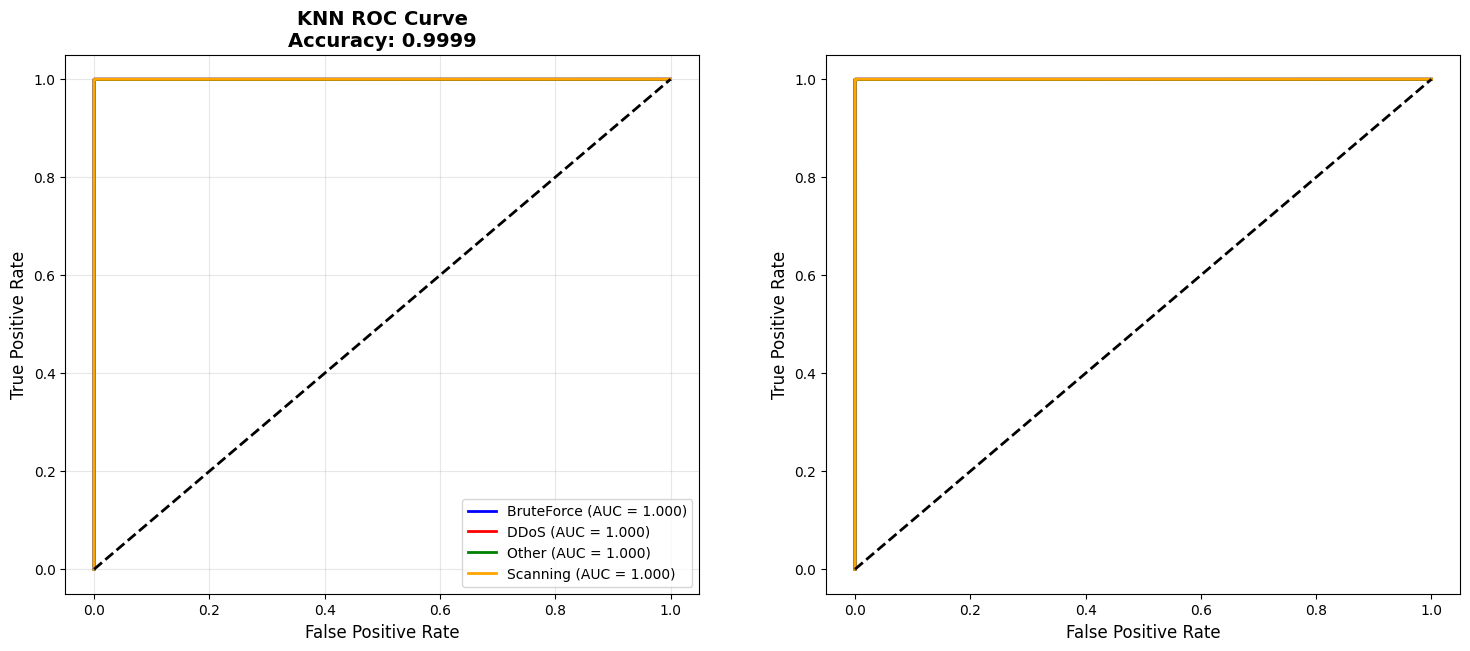

In [17]:
print("\n" + "="*70)
print("STEP 11: ENSEMBLE LEARNING (Soft Voting)")
print("="*70)

ensemble = VotingClassifier(
    estimators=[
        ('knn', best_knn),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)

ensemble_pred = ensemble.predict(X_test)
ensemble_probs = ensemble.predict_proba(X_test)

ensemble_acc = accuracy_score(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_probs, multi_class="ovr")

print(f"Ensemble Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble ROC-AUC: {ensemble_auc:.4f}")

# Add to results
ml_results_df = pd.concat([ml_results_df, pd.DataFrame([{
    "Model": "Ensemble (Voting)",
    "CV Mean": np.nan,
    "CV Std": np.nan,
    "Accuracy": ensemble_acc,
    "Precision": precision_score(y_test, ensemble_pred, average="weighted"),
    "Recall": recall_score(y_test, ensemble_pred, average="weighted"),
    "F1-score": f1_score(y_test, ensemble_pred, average="weighted"),
    "ROC-AUC": ensemble_auc
}])], ignore_index=True)

print("\n📊 Updated Results with Ensemble:")
print(ml_results_df.to_string(index=False))

# ============================================
# 1️⃣4️⃣ ROC CURVES (Multi-class)
# ============================================
print("\n" + "="*70)
print("STEP 12: ROC CURVE VISUALIZATION")
print("="*70)

y_test_bin = label_binarize(y_test, classes=np.unique(y_bal))
n_classes = len(le.classes_)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

# KNN ROC
knn_proba = best_knn.predict_proba(X_test)
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], knn_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=color, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'KNN ROC Curve\nAccuracy: {ml_results_df[ml_results_df.Model=="KNN"]["Accuracy"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# XGBoost ROC
xgb_proba = best_xgb.predict_proba(X_test)
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], xgb_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'XGBoost ROC Curve (Optuna)\nROC-AUC: {ml_results_df[ml_results_df.Model=="XGBoost (Optuna)"]["ROC-AUC"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 1️⃣4️⃣ ROC CURVES (Multi-class)


STEP 12: ROC CURVE VISUALIZATION


IndexError: index 0 is out of bounds for axis 0 with size 0

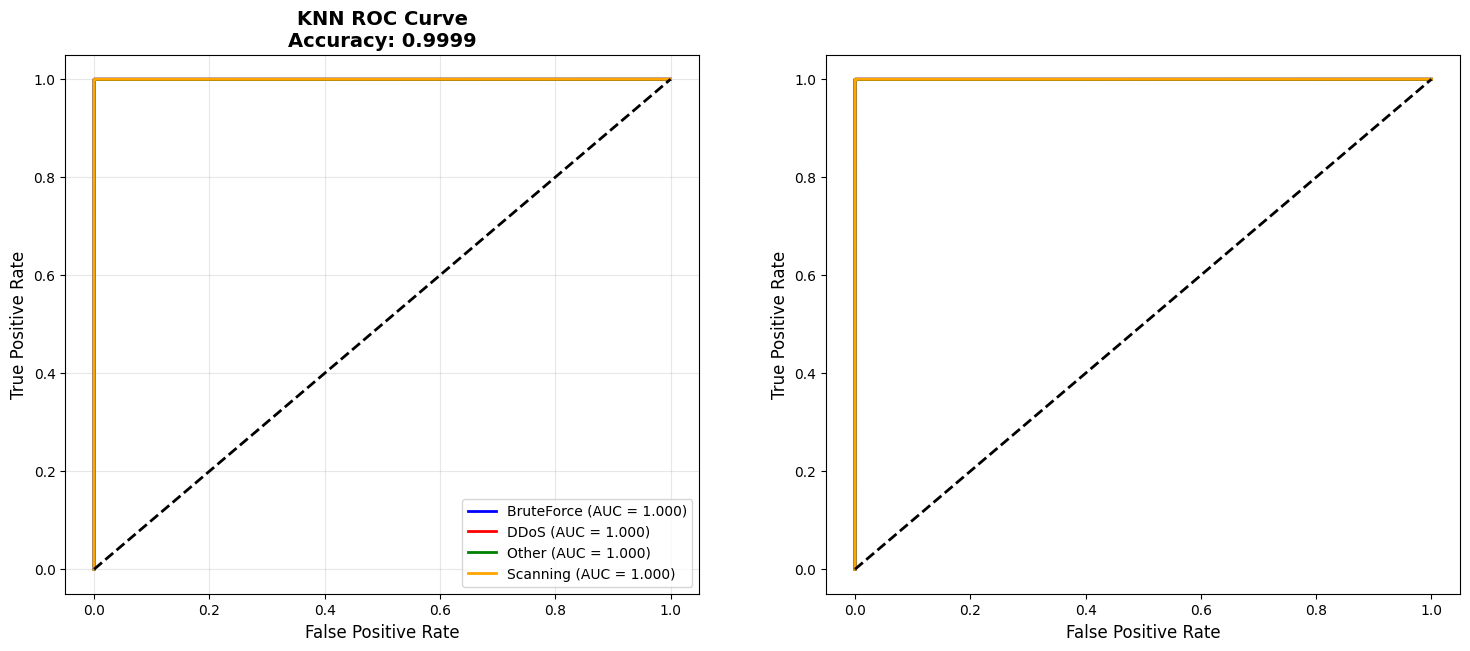

In [18]:
print("\n" + "="*70)
print("STEP 12: ROC CURVE VISUALIZATION")
print("="*70)

y_test_bin = label_binarize(y_test, classes=np.unique(y_bal))
n_classes = len(le.classes_)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

# KNN ROC
knn_proba = best_knn.predict_proba(X_test)
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], knn_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=color, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title(f'KNN ROC Curve\nAccuracy: {ml_results_df[ml_results_df.Model=="KNN"]["Accuracy"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# XGBoost ROC
xgb_proba = best_xgb.predict_proba(X_test)
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], xgb_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title(f'XGBoost ROC Curve (Optuna)\nROC-AUC: {ml_results_df[ml_results_df.Model=="XGBoost (Optuna)"]["ROC-AUC"].values[0]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 1️⃣5️⃣ CONFUSION MATRICES

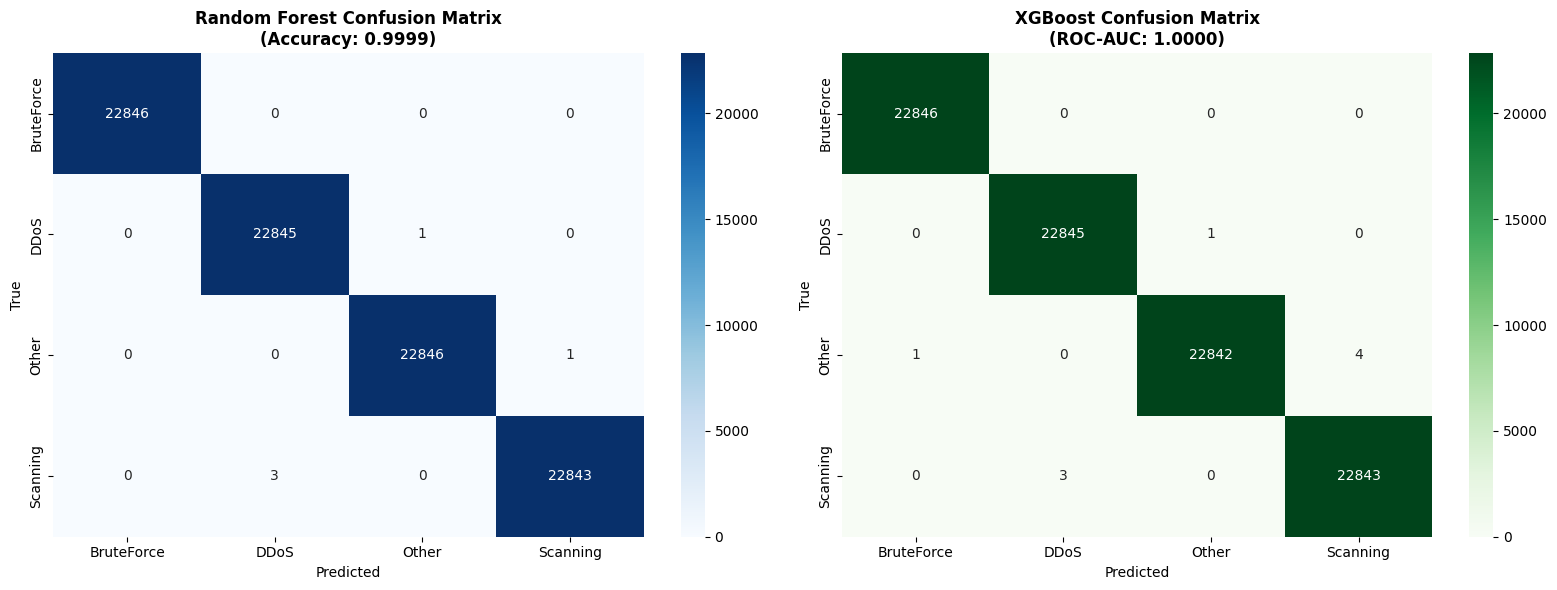

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KNN
knn_pred = models["Random Forest"].predict(X_test)
cm_knn = confusion_matrix(y_test, knn_pred)
sns.heatmap(
    cm_knn, annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues", ax=axes[0]
)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title(f'Random Forest Confusion Matrix\n(Accuracy: {ml_results_df[ml_results_df.Model=="Random Forest"]["Accuracy"].values[0]:.4f})', 
                  fontweight='bold')

# XGBoost
xgb_pred = models["XGBoost"].predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(
    cm_xgb, annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Greens", ax=axes[1]
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title(f'XGBoost Confusion Matrix\n(ROC-AUC: {ml_results_df[ml_results_df.Model=="XGBoost"]["ROC-AUC"].values[0]:.4f})', 
                  fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
print("\n" + "="*70)
print("TRAINING DEEP LEARNING MODELS")
print("="*70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare tensors
Xtr = torch.tensor(X_train, dtype=torch.float32).to(device)
Xte = torch.tensor(X_test, dtype=torch.float32).to(device)
ytr = torch.tensor(y_train, dtype=torch.long).to(device)
yte = torch.tensor(y_test, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(Xte, yte), batch_size=256, shuffle=False)

# DL Model Definitions
class CNN(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.conv = nn.Conv1d(1, 64, 3, padding=1)
        self.bn = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64*d, c)
    
    def forward(self, x):
        x = self.conv(x.unsqueeze(1))
        x = self.bn(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.fc(x.view(x.size(0), -1))

class LSTM(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.lstm = nn.LSTM(d, 128, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(128, c)
    
    def forward(self, x):
        _, (h, _) = self.lstm(x.unsqueeze(1))
        return self.fc(h[-1])

class Autoencoder(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32), nn.ReLU()
        )
        self.classifier = nn.Linear(32, c)
    
    def forward(self, x):
        return self.classifier(self.encoder(x))

class Transformer(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.emb = nn.Linear(d, 128)
        layer = nn.TransformerEncoderLayer(128, 8, 512, batch_first=True, dropout=0.3)
        self.transformer = nn.TransformerEncoder(layer, 3)
        self.fc = nn.Linear(128, c)
    
    def forward(self, x):
        x = self.transformer(self.emb(x).unsqueeze(1))
        return self.fc(x[:, 0])

# Training function
def train_dl(model, epochs=20, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation function
def eval_dl(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds.extend(model(xb).argmax(1).cpu())
            trues.extend(yb.cpu())
    return (
        accuracy_score(trues, preds),
        precision_score(trues, preds, average="weighted", zero_division=0),
        recall_score(trues, preds, average="weighted"),
        f1_score(trues, preds, average="weighted")
    )

# Train all DL models
d_features = X_sel.shape[1]
n_classes = len(le.classes_)

dl_models = {
    "CNN": CNN(d_features, n_classes),
    "LSTM": LSTM(d_features, n_classes),
    "Autoencoder": Autoencoder(d_features, n_classes),
    "Transformer": Transformer(d_features, n_classes)
}

dl_results = []

for name, model in dl_models.items():
    print(f"\nTraining {name}...")
    train_dl(model, epochs=20)
    metrics = eval_dl(model)
    dl_results.append([name, *metrics])
    print(f"   Accuracy: {metrics[0]:.4f}")

dl_results_df = pd.DataFrame(
    dl_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

print("\n📊 Deep Learning Results:")
print(dl_results_df.to_string(index=False))



TRAINING DEEP LEARNING MODELS
Using device: cuda

Training CNN...
   Epoch 5/20, Loss: 0.0865
   Epoch 10/20, Loss: 0.0735
   Epoch 15/20, Loss: 0.0672
   Epoch 20/20, Loss: 0.0630
   Accuracy: 0.9829

Training LSTM...
   Epoch 5/20, Loss: 0.0408
   Epoch 10/20, Loss: 0.0254
   Epoch 15/20, Loss: 0.0210
   Epoch 20/20, Loss: 0.0164
   Accuracy: 0.9963

Training Autoencoder...
   Epoch 5/20, Loss: 0.0473
   Epoch 10/20, Loss: 0.0377
   Epoch 15/20, Loss: 0.0339
   Epoch 20/20, Loss: 0.0301
   Accuracy: 0.9926

Training Transformer...
   Epoch 5/20, Loss: 0.0644
   Epoch 10/20, Loss: 0.0516
   Epoch 15/20, Loss: 0.0498
   Epoch 20/20, Loss: 0.0430
   Accuracy: 0.9912

📊 Deep Learning Results:
      Model  Accuracy  Precision   Recall  F1-score
        CNN  0.982929   0.983341 0.982929  0.982886
       LSTM  0.996323   0.996330 0.996323  0.996321
Autoencoder  0.992636   0.992692 0.992636  0.992634
Transformer  0.991235   0.991284 0.991235  0.991226


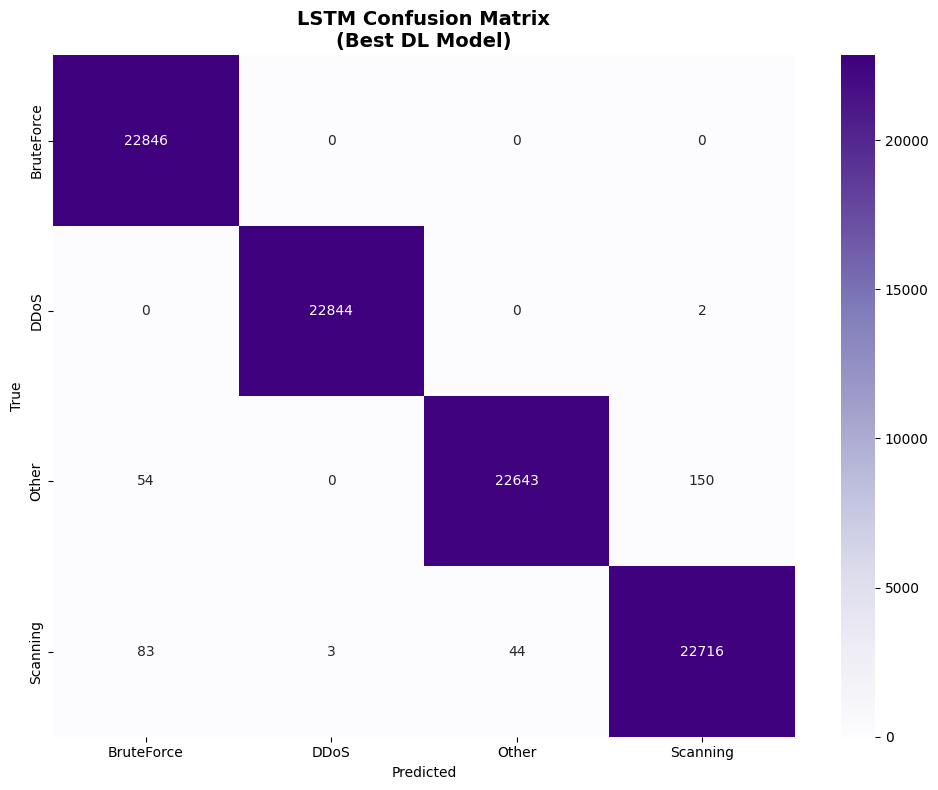

In [27]:
best_dl_name = dl_results_df.loc[dl_results_df['Accuracy'].idxmax(), 'Model']
best_dl_model = dl_models[best_dl_name]

dl_pred = best_dl_model(Xte).argmax(1).cpu().numpy()
cm_dl = confusion_matrix(y_test, dl_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_dl, annot=True, fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Purples"
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_dl_name} Confusion Matrix\n(Best DL Model)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Enhanced SHAP Analysis

Running simplified SHAP analysis...

📊 XGBoost Feature Importance (Gain):
                 Feature  Importance
   flow_pkts_payload.std    0.229023
             bwd_iat.min    0.166177
             service_ssl    0.114196
              Unnamed: 0    0.080153
   flow_pkts_payload.max    0.075224
    fwd_pkts_payload.avg    0.060804
             service_dns    0.056793
    fwd_pkts_payload.min    0.042135
payload_bytes_per_second    0.039492
    bwd_init_window_size    0.030286
            service_http    0.029706
              active.avg    0.019736
    fwd_pkts_payload.max    0.017334
     flow_SYN_flag_count    0.010888
               service_-    0.008424


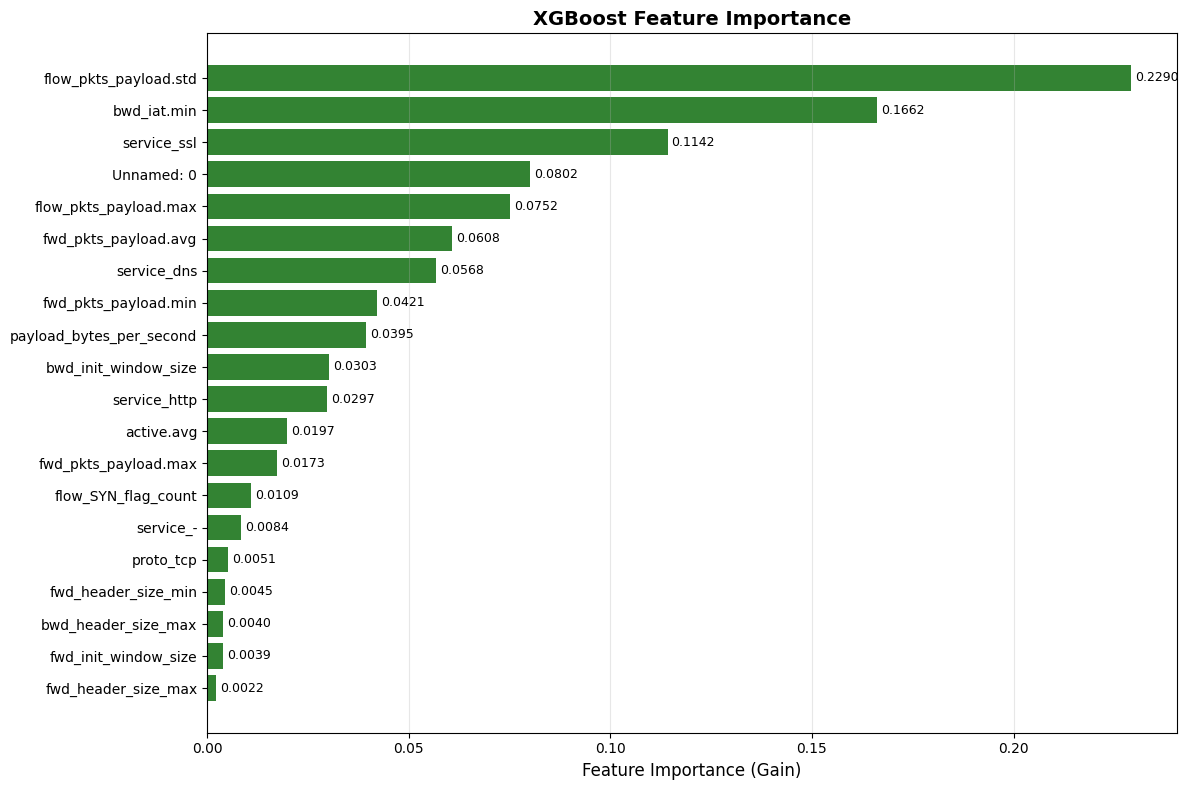


📊 SHAP Feature Importance (Top 15):
                 Feature  SHAP_Importance
              Unnamed: 0         2.280862
   flow_pkts_payload.std         0.604608
payload_bytes_per_second         0.578198
    fwd_pkts_payload.min         0.569318
              active.avg         0.526883
   flow_pkts_payload.max         0.486839
    fwd_pkts_payload.avg         0.466815
    fwd_pkts_payload.max         0.340497
             bwd_iat.min         0.262463
               service_-         0.245089
     flow_SYN_flag_count         0.185417
    bwd_init_window_size         0.139133
             service_dns         0.127191
            service_http         0.114555
     bwd_header_size_max         0.112458

📊 Comparison of Feature Importance Methods:
                 Feature  XGBoost_Importance  SHAP_Importance
   flow_pkts_payload.std            0.229023         0.604608
             bwd_iat.min            0.166177         0.262463
             service_ssl            0.114196         0.02249

In [31]:
import numpy as np

print("Running simplified SHAP analysis...")

# Get XGBoost model
xgb_model = models["XGBoost"]

# Get feature importance from XGBoost directly
xgb_importances = xgb_model.feature_importances_

# Create feature importance DataFrame
feature_importance_xgb = pd.DataFrame({
    'Feature': selected_features[:len(xgb_importances)],
    'Importance': xgb_importances
}).sort_values('Importance', ascending=False)

print("\n📊 XGBoost Feature Importance (Gain):")
print(feature_importance_xgb.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance_xgb))
bars = plt.barh(range(top_n), 
                feature_importance_xgb['Importance'].head(top_n)[::-1],
                color='darkgreen', alpha=0.8)

# Add value labels
for i, (idx, row) in enumerate(feature_importance_xgb.head(top_n)[::-1].iterrows()):
    plt.text(row['Importance'] + 0.001, i, 
             f'{row["Importance"]:.4f}', 
             va='center', fontsize=9)

plt.yticks(range(top_n), 
           feature_importance_xgb['Feature'].head(top_n)[::-1], fontsize=10)
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Simple SHAP without complex plots
try:
    import shap
    
    # Fix numpy compatibility
    if not hasattr(np, 'int'):
        np.int = np.int64
    
    # Create explainer
    explainer = shap.TreeExplainer(xgb_model)
    
    # Get SHAP values for a subset (for speed)
    sample_indices = np.random.choice(len(X_test), size=min(1000, len(X_test)), replace=False)
    X_test_sample = X_test[sample_indices]
    
    # Calculate SHAP values
    shap_values_sample = explainer.shap_values(X_test_sample)
    
    # Convert to appropriate format
    if isinstance(shap_values_sample, list):
        shap_array_sample = np.array(shap_values_sample)
        shap_mean_abs = np.abs(shap_array_sample).mean(axis=(0, 1))
    else:
        shap_mean_abs = np.abs(shap_values_sample).mean(axis=0)
    
    # Create SHAP importance DataFrame
    shap_importance = pd.DataFrame({
        'Feature': selected_features[:len(shap_mean_abs)],
        'SHAP_Importance': shap_mean_abs
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\n📊 SHAP Feature Importance (Top 15):")
    print(shap_importance.head(15).to_string(index=False))
    
    # Compare XGBoost importance vs SHAP importance
    comparison = pd.merge(
        feature_importance_xgb.head(20).rename(columns={'Importance': 'XGBoost_Importance'}),
        shap_importance.head(20).rename(columns={'SHAP_Importance': 'SHAP_Importance'}),
        on='Feature',
        how='outer'
    ).fillna(0)
    
    print("\n📊 Comparison of Feature Importance Methods:")
    print(comparison.head(10).to_string(index=False))
    
except Exception as e:
    print(f"SHAP analysis failed: {e}")
    print("Using XGBoost feature importance instead.")

In [33]:
dataset_stats = pd.DataFrame({
    "Metric": ["Total Samples", "Features", "Classes", "Imbalance Ratio"],
    "Value": [len(df), X.shape[1], len(le.classes_), 
              f"{class_dist.max()/class_dist.min():.2f}:1"]
})